In [2]:
import os
from PIL import Image
import itertools

import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Activation, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

print('Modules Loaded')

Modules Loaded


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train_data = '/content/drive/MyDrive/TKTB1/chestxray/dataset'
filepaths = []
labels = []

folds = os.listdir(train_data)
for fold in folds:
    foldpath = os.path.join(train_data, fold)
    filelist = os.listdir(foldpath)

    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')

df = pd.concat([FSeries, LSeries], axis=1)
df

filepaths      label
0     /content/drive/MyDrive/TKTB1/chestxray/dataset...     NORMAL
1     /content/drive/MyDrive/TKTB1/chestxray/dataset...     NORMAL
2     /content/drive/MyDrive/TKTB1/chestxray/dataset...     NORMAL
3     /content/drive/MyDrive/TKTB1/chestxray/dataset...     NORMAL
4     /content/drive/MyDrive/TKTB1/chestxray/dataset...     NORMAL
...                                                 ...        ...
2683  /content/drive/MyDrive/TKTB1/chestxray/dataset...  PNEUMONIA
2684  /content/drive/MyDrive/TKTB1/chestxray/dataset...  PNEUMONIA
2685  /content/drive/MyDrive/TKTB1/chestxray/dataset...  PNEUMONIA
2686  /content/drive/MyDrive/TKTB1/chestxray/dataset...  PNEUMONIA
2687  /content/drive/MyDrive/TKTB1/chestxray/dataset...  PNEUMONIA

[2688 rows x 2 columns]

In [5]:
valid_data = '/content/drive/MyDrive/TKTB1/chestxray/val'
filepaths = []
labels = []

folds = os.listdir(valid_data)
for fold in folds:
    foldpath = os.path.join(valid_data, fold)
    filelist = os.listdir(foldpath)

    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')

valid = pd.concat([FSeries, LSeries], axis=1)
valid

filepaths      label
0   /content/drive/MyDrive/TKTB1/chestxray/val/NOR...     NORMAL
1   /content/drive/MyDrive/TKTB1/chestxray/val/NOR...     NORMAL
2   /content/drive/MyDrive/TKTB1/chestxray/val/NOR...     NORMAL
3   /content/drive/MyDrive/TKTB1/chestxray/val/NOR...     NORMAL
4   /content/drive/MyDrive/TKTB1/chestxray/val/NOR...     NORMAL
5   /content/drive/MyDrive/TKTB1/chestxray/val/NOR...     NORMAL
6   /content/drive/MyDrive/TKTB1/chestxray/val/NOR...     NORMAL
7   /content/drive/MyDrive/TKTB1/chestxray/val/NOR...     NORMAL
8   /content/drive/MyDrive/TKTB1/chestxray/val/PNE...  PNEUMONIA
9   /content/drive/MyDrive/TKTB1/chestxray/val/PNE...  PNEUMONIA
10  /content/drive/MyDrive/TKTB1/chestxray/val/PNE...  PNEUMONIA
11  /content/drive/MyDrive/TKTB1/chestxray/val/PNE...  PNEUMONIA
12  /content/drive/MyDrive/TKTB1/chestxray/val/PNE...  PNEUMONIA
13  /content/drive/MyDrive/TKTB1/chestxray/val/PNE...  PNEUMONIA
14  /content/drive/MyDrive/TKTB1/chestxray/val/PNE...  PNEUMONIA
15  /content/drive/MyDrive/TKTB1/chestxray/val/PNE...  PNEUMONIA

In [6]:
test_data = '/content/drive/MyDrive/TKTB1/chestxray/test'
filepaths = []
labels = []

folds = os.listdir(test_data)

for fold in folds:
    foldpath = os.path.join(test_data,fold)
    filelist = os.listdir(foldpath)

    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')

test = pd.concat([FSeries, LSeries], axis=1)
test

filepaths      label
0    /content/drive/MyDrive/TKTB1/chestxray/test/PN...  PNEUMONIA
1    /content/drive/MyDrive/TKTB1/chestxray/test/PN...  PNEUMONIA
2    /content/drive/MyDrive/TKTB1/chestxray/test/PN...  PNEUMONIA
3    /content/drive/MyDrive/TKTB1/chestxray/test/PN...  PNEUMONIA
4    /content/drive/MyDrive/TKTB1/chestxray/test/PN...  PNEUMONIA
..                                                 ...        ...
619  /content/drive/MyDrive/TKTB1/chestxray/test/NO...     NORMAL
620  /content/drive/MyDrive/TKTB1/chestxray/test/NO...     NORMAL
621  /content/drive/MyDrive/TKTB1/chestxray/test/NO...     NORMAL
622  /content/drive/MyDrive/TKTB1/chestxray/test/NO...     NORMAL
623  /content/drive/MyDrive/TKTB1/chestxray/test/NO...     NORMAL

[624 rows x 2 columns]

In [7]:
train_df, dummy_df = train_test_split(df,train_size=0.8,shuffle=True, random_state=42)
valid_df, test_df = train_test_split(dummy_df, train_size=0.5,shuffle=True, random_state=42)

In [8]:
batch_size = 16
img_size = (224, 224)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
val_gen= ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = val_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 2150 validated image filenames belonging to 2 classes.
Found 269 validated image filenames belonging to 2 classes.
Found 269 validated image filenames belonging to 2 classes.


In [9]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images, labels = next(train_gen)

plt.figure(figsize=(20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255.0
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')

plt.show()


In [10]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_count = len(list(train_gen.class_indices.keys()))

model = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape),
    MaxPooling2D((2, 2)),

    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape),
    MaxPooling2D((2, 2)),

    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),


    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(256,activation = "relu"),
    Dropout(0.3),
    Dense(128,activation = "relu"),
    Dropout(0.3),
    Dense(class_count, activation = "softmax")
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 14, 14, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,024,514 (30.61 MB)

 Trainable params: 8,024,514 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
epochs = 10

history = model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 486s 4s/step - accuracy: 0.7037 - loss: 4.6814 - val_accuracy: 0.9368 - val_loss: 0.2082
Epoch 2/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 445s 3s/step - accuracy: 0.9365 - loss: 0.1706 - val_accuracy: 0.9628 - val_loss: 0.1322
Epoch 3/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 474s 4s/step - accuracy: 0.9619 - loss: 0.1217 - val_accuracy: 0.9628 - val_loss: 0.1484
Epoch 4/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 439s 3s/step - accuracy: 0.9703 - loss: 0.0699 - val_accuracy: 0.9517 - val_loss: 0.1666
Epoch 5/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 439s 3s/step - accuracy: 0.9866 - loss: 0.0436 - val_accuracy: 0.9442 - val_loss: 0.2215
Epoch 6/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 440s 3s/step - accuracy: 0.9885 - loss: 0.0339 - val_accuracy: 0.9665 - val_loss: 0.1236
Epoch 7/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 450s 3s/step - accuracy: 0.9953 - loss: 0.0201 - val_accuracy: 0.9591 - val_loss: 0.1851
Epoch 8/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 436s 3s/step - accuracy: 0.9894 - loss: 0.0287 - val_accu

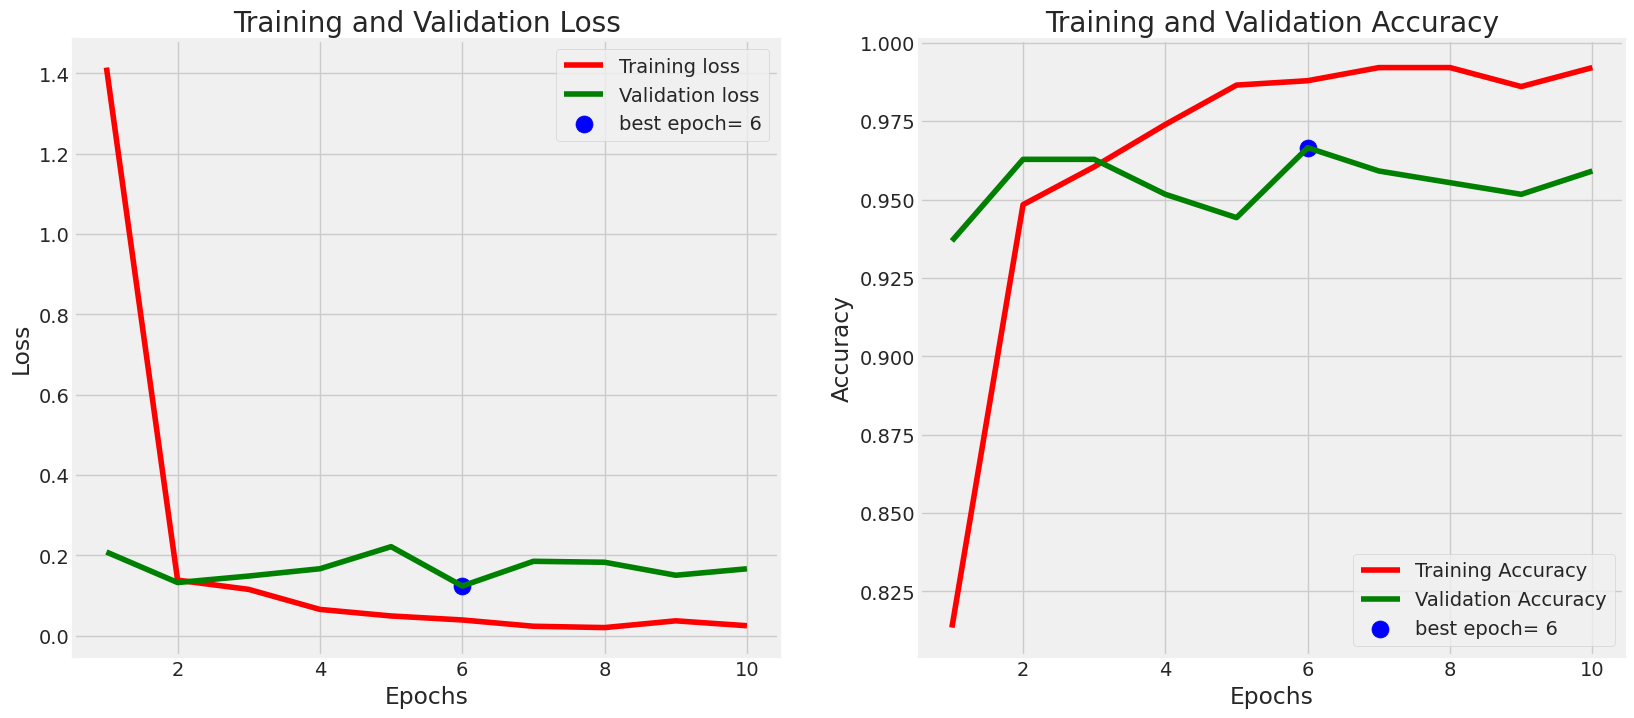

In [12]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [13]:
loss,test=model.evaluate(test_gen)
print("loss : ",loss)
print("accuracy : ",test)

17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9757 - loss: 0.0761
loss :  0.08117808401584625
accuracy :  0.9776951670646667


In [19]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

17/17 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step


In [20]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())
cm = confusion_matrix(test_gen.classes, y_pred)
cm

array([[134,   2],
       [  4, 129]])

In [21]:
from sklearn.metrics import classification_report
print(classification_report(test_gen.classes,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       136
           1       0.98      0.97      0.98       133

    accuracy                           0.98       269
   macro avg       0.98      0.98      0.98       269
weighted avg       0.98      0.98      0.98       269



In [23]:
import numpy as np
import matplotlib.pyplot as plt

preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

g_dict = test_gen.class_indices
classes = list(g_dict.keys())

plt.figure(figsize=(20,20))

for i in range(25):
    img, label = test_gen[i][0][0], test_gen[i][1][0]
    true_label_index = np.argmax(label)
    true_label = 'normal' if true_label_index == 0 else 'pneumonia'

    predicted_label = 'normal' if y_pred[i] == 0 else 'pneumonia'

    img = img * 255
    img = img.astype(np.uint8)

    plt.subplot(5, 5, i + 1)
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPred: {predicted_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step


ValueError: Asked to retrieve element 17, but the Sequence has length 17

In [27]:
plt.figure(figsize=(20, 20))

num_samples = min(len(test_gen), 25)  # Pastikan tidak melebihi jumlah batch
for i in range(num_samples):
    img, label = test_gen[i][0][0], test_gen[i][1][0]
    true_label_index = np.argmax(label)
    true_label = 'normal' if true_label_index == 0 else 'pneumonia'

    predicted_label = 'normal' if y_pred[i] == 0 else 'pneumonia'

    img = img * 255
    img = img.astype(np.uint8)

    plt.subplot(5, 5, i + 1)
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPred: {predicted_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [26]:
model.save('/content/drive/MyDrive/SMT 7/model_pertama.h5', save_format="tf")
